In [1]:
import os
import pathlib

import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import scipy.io as sio
from matplotlib import pyplot
from tensorflow.keras.layers.experimental import preprocessing
from tensorflow.keras import layers
from keras.models import load_model
from tensorflow.keras import models
from tensorflow import keras
import pandas as pd

from keras.callbacks import EarlyStopping, ModelCheckpoint
from IPython import display

MODELS_DIR = 'models/'
if not os.path.exists(MODELS_DIR):
    os.mkdir(MODELS_DIR)
MODEL_TF = MODELS_DIR + 'model'
MODEL_NO_QUANT_TFLITE = MODELS_DIR + 'model_no_quant.tflite'
MODEL_TFLITE = MODELS_DIR + 'model.tflite'
MODEL_TFLITE_MICRO = MODELS_DIR + 'model.cc'

In [3]:
def predict_tflite(tflite_model, x_test):
  # Prepare the test data
  x_test_ = x_test.copy()
  #x_test_ = x_test_.reshape((x_test.size, 1))
  x_test_ = x_test_.astype(np.float32)

  # Initialize the TFLite interpreter
  interpreter = tf.lite.Interpreter(model_content=tflite_model)
  interpreter.allocate_tensors()

  input_details = interpreter.get_input_details()[0]
  output_details = interpreter.get_output_details()[0]

  # If required, quantize the input layer (from float to integer)
  input_scale, input_zero_point = input_details["quantization"]
  if (input_scale, input_zero_point) != (0.0, 0):
    x_test_ = x_test_ / input_scale + input_zero_point
    x_test_ = x_test_.astype(input_details["dtype"])
  # Invoke the interpreter
  interpreter.set_tensor(input_details["index"], x_test_)
  interpreter.invoke()
  y_pred = interpreter.get_tensor(output_details["index"])[0]

  # If required, dequantized the output layer (from integer to float)
  output_scale, output_zero_point = output_details["quantization"]
  if (output_scale, output_zero_point) != (0.0, 0):
    y_pred = y_pred.astype(np.float32)
    y_pred = (y_pred - output_zero_point) * output_scale

  return y_pred

# Read training, validation and test data

In [2]:
data_train=sio.loadmat('./Dataset/commands_train.mat') #Change this to point to your dataset
Input_train=data_train['Input_train']
Input_train=np.reshape(Input_train,[Input_train.shape[0],1,Input_train.shape[1],1])
Label_train=data_train['Label_train']

data_val=sio.loadmat('./Dataset/commands_val.mat') #Change this to point to your dataset
Input_val=data_val['Input_val']
Input_val=np.reshape(Input_val,[Input_val.shape[0],1,Input_val.shape[1],1])
Label_val=data_val['Label_val']


data_test=sio.loadmat('./Dataset/commands_test.mat') #Change this to point to your dataset
Input_test=data_test['Input_test']
Input_test=np.reshape(Input_test,[Input_test.shape[0],1,Input_test.shape[1],1])
Label_test=data_test['Label_test']

Label_train= tf.keras.utils.to_categorical(Label_train)
Label_val= tf.keras.utils.to_categorical(Label_val)

In [4]:
Input_train.shape

(6000, 1, 16000, 1)

# Create a model

In [4]:
model = tf.keras.Sequential()
model.add(layers.Conv2D(filters=4,kernel_size=[1,15],activation='relu', input_shape=(1,16000,1)))
model.add(layers.MaxPooling2D(pool_size=[1,5]))
model.add(layers.Conv2D(filters=4,kernel_size=[1,9],activation='relu'))
model.add(layers.MaxPooling2D(pool_size=[1,3]))

model.add(layers.Conv2D(filters=4,kernel_size=[1,12],activation='relu'))
model.add(layers.MaxPooling2D(pool_size=[1,3]))
model.add(layers.Conv2D(filters=4,kernel_size=[1,9],activation='relu'))
model.add(layers.MaxPooling2D(pool_size=[1,3]))

model.add(layers.Conv2D(filters=4,kernel_size=[1,5],activation='relu'))
model.add(layers.MaxPooling2D(pool_size=[1,3]))
model.add(layers.Conv2D(filters=8,kernel_size=[1,3],activation='relu'))
model.add(layers.MaxPooling2D(pool_size=[1,2]))

model.add(layers.Conv2D(filters=16,kernel_size=[1,3],activation='relu'))
model.add(layers.MaxPooling2D(pool_size=[1,2]))

model.add(layers.Flatten())
model.add(layers.Dense(2,activation='softmax', input_shape=(16000,)))
#model.add(layers.Dropout(0.25))

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 1, 15986, 4)       64        
                                                                 
 max_pooling2d (MaxPooling2  (None, 1, 3197, 4)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 1, 3189, 4)        148       
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 1, 1063, 4)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 1, 1052, 4)        196       
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 1, 350, 4)         0

2024-02-20 17:01:17.258369: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M1 Pro
2024-02-20 17:01:17.258401: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 32.00 GB
2024-02-20 17:01:17.258409: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 10.67 GB
2024-02-20 17:01:17.258450: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2024-02-20 17:01:17.258476: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


# Fit the model

In [5]:
#opt = keras.optimizers.Adam(learning_rate=0.003, weight_decay = 0.0015)
opt = keras.optimizers.legacy.Adam(learning_rate=0.003, decay = 0.0015)
model.compile(optimizer=opt, loss=tf.keras.losses.CategoricalCrossentropy (), metrics=['accuracy'])

EPOCHS =200
callbacks = [EarlyStopping(monitor='val_loss', patience=20), ModelCheckpoint(filepath='best_model.h5', monitor='val_loss', save_best_only=True)]# uses validation set to stop training when it start overfitting
history = model.fit(Input_train,Label_train,validation_data=(Input_val,Label_val),epochs=EPOCHS,callbacks=callbacks,batch_size=32, verbose=1, shuffle=True)

Epoch 1/200


2024-02-20 17:01:30.645294: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


188/188 [==============================] - 4s 21ms/step - loss: 0.5836 - accuracy: 0.6693 - val_loss: 0.4600 - val_accuracy: 0.8159
Epoch 2/200
  7/188 [>.............................] - ETA: 3s - loss: 0.3396 - accuracy: 0.8884

/Users/xiaowen/miniconda3/lib/python3.11/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


188/188 [==============================] - 4s 19ms/step - loss: 0.2994 - accuracy: 0.8840 - val_loss: 0.2624 - val_accuracy: 0.9005
Epoch 3/200
188/188 [==============================] - 4s 19ms/step - loss: 0.1979 - accuracy: 0.9317 - val_loss: 0.2186 - val_accuracy: 0.9229
Epoch 4/200
188/188 [==============================] - 4s 19ms/step - loss: 0.1430 - accuracy: 0.9547 - val_loss: 0.2087 - val_accuracy: 0.9378
Epoch 5/200
188/188 [==============================] - 4s 19ms/step - loss: 0.1139 - accuracy: 0.9657 - val_loss: 0.1822 - val_accuracy: 0.9502
Epoch 6/200
188/188 [==============================] - 4s 19ms/step - loss: 0.1039 - accuracy: 0.9660 - val_loss: 0.1519 - val_accuracy: 0.9403
Epoch 7/200
188/188 [==============================] - 4s 20ms/step - loss: 0.0954 - accuracy: 0.9710 - val_loss: 0.1222 - val_accuracy: 0.9652
Epoch 8/200
188/188 [==============================] - 4s 19ms/step - loss: 0.0844 - accuracy: 0.9785 - val_loss: 0.4689 - val_accuracy: 0.8930
Epoc

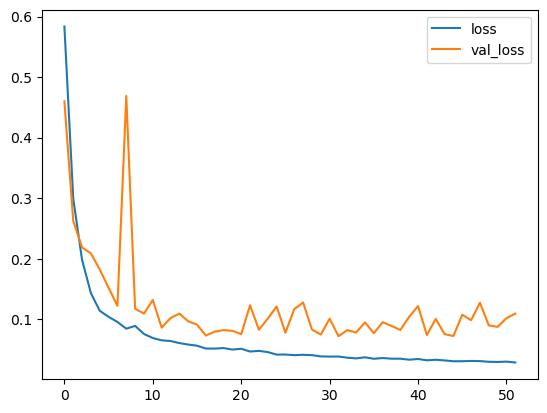

In [6]:
metrics = history.history
plt.plot(history.epoch, metrics['loss'], metrics['val_loss'])
plt.legend(['loss', 'val_loss'])
plt.show()

# Check test accuracy

In [7]:
model = load_model('./best_model.h5')
model.save(MODEL_TF)
y_pred = np.reshape(np.argmax(model.predict(Input_test), axis=1),[len(Input_test),1])
y_true = Label_test

test_acc = float(sum(y_pred == y_true) / len(y_true))
print('Test accuracy is:')
print(f"{test_acc:.2%}")

model.save(f"./test_acc_{test_acc:.4}.h5")

INFO:tensorflow:Assets written to: models/model/assets


INFO:tensorflow:Assets written to: models/model/assets


13/13 [==============================] - 0s 6ms/step
Test accuracy is:
99.00%


/var/folders/b_/jdvks4w5307150c7gr8jtgmc0000gn/T/ipykernel_82430/3080518831.py:6: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  test_acc = float(sum(y_pred == y_true) / len(y_true))
/Users/xiaowen/miniconda3/lib/python3.11/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [8]:
converter = tf.lite.TFLiteConverter.from_saved_model(MODEL_TF)
model_no_quant_tflite = converter.convert()

# Save the model to disk
open(MODEL_NO_QUANT_TFLITE, "wb").write(model_no_quant_tflite)
def representative_dataset():
  for i in range(500):
    yield([Input_train[i,:,:,:].reshape(1,1,16000,1).astype(np.float32)])

# Set the optimization flag.
converter.optimizations = [tf.lite.Optimize.DEFAULT]
# Enforce integer only quantization
converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS_INT8]
converter.inference_input_type = tf.int8
converter.inference_output_type = tf.int8
# Provide a representative dataset to ensure we quantize correctly.
converter.representative_dataset = representative_dataset
model_tflite = converter.convert()

# Save the model to disk
open(MODEL_TFLITE, "wb").write(model_tflite)

2024-02-20 17:05:52.434152: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:378] Ignored output_format.
2024-02-20 17:05:52.434171: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:381] Ignored drop_control_dependency.
2024-02-20 17:05:52.434449: I tensorflow/cc/saved_model/reader.cc:83] Reading SavedModel from: models/model
2024-02-20 17:05:52.435704: I tensorflow/cc/saved_model/reader.cc:51] Reading meta graph with tags { serve }
2024-02-20 17:05:52.435710: I tensorflow/cc/saved_model/reader.cc:146] Reading SavedModel debug info (if present) from: models/model
2024-02-20 17:05:52.437862: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:388] MLIR V1 optimization pass is not enabled
2024-02-20 17:05:52.438981: I tensorflow/cc/saved_model/loader.cc:233] Restoring SavedModel bundle.
2024-02-20 17:05:52.478022: I tensorflow/cc/saved_model/loader.cc:217] Running initialization op on SavedModel bundle at path: models/model
2024-02-20 17:05:52

10040

In [9]:
# Calculate predictions with full software
y_pred = np.reshape(np.argmax(model.predict(Input_test), axis=1),[len(Input_test),1])
y_true = Label_test

test_acc = float(sum(y_pred == y_true) / len(y_true))
print('Test accuracy with model:')
print(f"{test_acc:.2%}")
y_test_pred_no_quant_tflite=np.empty([Input_test.shape[0],1])
y_test_pred_tflite=np.empty([Input_test.shape[0],1])
# Calculate predictions with tensorflow lite
for i in range(0,Input_test.shape[0]):
  y_test_pred_no_quant_tflite[i,0]=np.argmax(predict_tflite(model_no_quant_tflite, Input_test[i:i+1,:,:,:]))

test_acc = float(sum(y_test_pred_no_quant_tflite == y_true) / len(y_true))
print('Test accuracy with model tf lite:')
print(f"{test_acc:.2%}")

# Calculate predictions with tensorflow lite quantized model
for i in range(0,Input_test.shape[0]):
  y_test_pred_tflite[i,0]=np.argmax(predict_tflite(model_tflite, Input_test[i:i+1,:,:,:]))
y_true = Label_test

test_acc = float(sum(y_test_pred_tflite == y_true) / len(y_true))
print('Test accuracy with model quantized:')
print(f"{test_acc:.2%}")

y_test_pred_tflite=np.empty([Input_test.shape[0],2])

# Calculate predictions with tensorflow lite quantized model
for i in range(0,Input_test.shape[0]):
  y_test_pred_tflite[i,:]=(predict_tflite(model_tflite, Input_test[i:i+1,:,:,:]))
y_true = Label_test

y_test_tflite = {"y_test_pred_tflite":y_test_pred_tflite}
sio.savemat('models/tflite_pred.mat',y_test_tflite)

13/13 [==============================] - 0s 4ms/step
Test accuracy with model:
99.00%


/var/folders/b_/jdvks4w5307150c7gr8jtgmc0000gn/T/ipykernel_82430/2470856154.py:5: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  test_acc = float(sum(y_pred == y_true) / len(y_true))
INFO: Created TensorFlow Lite XNNPACK delegate for CPU.
/var/folders/b_/jdvks4w5307150c7gr8jtgmc0000gn/T/ipykernel_82430/2470856154.py:14: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  test_acc = float(sum(y_test_pred_no_quant_tflite == y_true) / len(y_true))


Test accuracy with model tf lite:
99.00%


/var/folders/b_/jdvks4w5307150c7gr8jtgmc0000gn/T/ipykernel_82430/2470856154.py:23: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  test_acc = float(sum(y_test_pred_tflite == y_true) / len(y_true))


Test accuracy with model quantized:
98.01%


Note depending on the model the quantized version might have higher accuracy.

In [10]:
# Calculate size
size_no_quant_tflite = os.path.getsize(MODEL_NO_QUANT_TFLITE)
size_tflite = os.path.getsize(MODEL_TFLITE)

# Compare size
# Compare size
pd.DataFrame.from_records(
    [["TensorFlow Lite", f"{size_no_quant_tflite} bytes ", f"(reduced by {0} bytes)"],
     ["TensorFlow Lite Quantized", f"{size_tflite} bytes", f"(reduced by {size_no_quant_tflite - size_tflite} bytes)"]],
     columns = ["Model", "Size", ""], index="Model")

Size                         
Model                                                           
TensorFlow Lite            11960 bytes      (reduced by 0 bytes)
TensorFlow Lite Quantized   10040 bytes  (reduced by 1920 bytes)